In [1]:
!pip install keras-tuner


     |████████████████████████████████| 96 kB 2.9 MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9568 sha256=7170918fa692abfc9ece0fb98f7894055712b980196f872df6037871352301f8
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built kt-legacy


In [2]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [3]:
tf.__version__

'2.5.0'

In [4]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
x_train.shape

(60000, 28, 28)

In [ ]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Text(0.5, 0, '9')

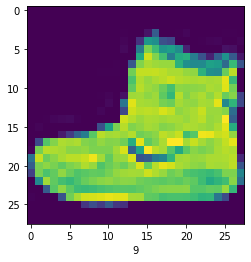

In [6]:
plt.imshow(x_train[0])
plt.xlabel(y_train[0])

In [7]:
def create_model(hp):

  num_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if hp:
    num_hidden_layers = hp.Choice('num_hidden_layers',values=[1,2,3])
    num_units = hp.Choice('num_units',values=[8,16,32])
    dropout_rate = hp.Float('droupout_rate',min_value=0.1,max_value=0.5)
    learning_rate = hp.Float('learning_rate',min_value=0.0001,max_value=0.01)


  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
  model.add(tf.keras.layers.Lambda(lambda x: x/255.))

  for _ in range(0,num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units,activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))


  model.add(tf.keras.layers.Dense(10,activation='softmax'))

  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics = ['accuracy']
  )
  return model

In [8]:
create_model(None).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [9]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
  def run_trial(self,trial,*args,**kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size',32,128,step=32)
    super(CustomTuner,self).run_trial(trial,*args,**kwargs)

In [10]:
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='logs',
    project_name='fashion_mnist',
    overwrite=True
  )

In [11]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
droupout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}


In [12]:
tuner.search(
    x_train, y_train,
    validation_data = (x_test,y_test),
    epochs=5,verbose=False
)

INFO:tensorflow:Oracle triggered exit


In [14]:
tuner.results_summary(1)

Results summary
Results in logs/fashion_mnist
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_hidden_layers: 3
num_units: 32
droupout_rate: 0.1
learning_rate: 0.004513852793928053
batch_size: 128
Score: 0.8528000116348267


In [15]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1

In [16]:
_ = model.fit(
    x_train,y_train,
    validation_data = (x_test,y_test),
    epochs=20,batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)]
)

Epoch 1/20


ValueError: ignored